In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
data_dir = "/kaggle/input/cucumber-disease-augmented-dataset/Augmented Image"

# Define transforms for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset (assuming subfolders for each class)
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Split into train and validation sets (80-20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to val_dataset
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get class names
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Number of classes: 8
Training samples: 5120, Validation samples: 1280


In [3]:
# ============================
# Load VGG16 (pre-trained on ImageNet)
# ============================
model = models.vgg16(pretrained=True)

# Replace the final classifier to match your dataset classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]


In [4]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [5]:
num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "densenet264_cucumber.pth")


Epoch 1/10


Validation: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Train Loss: 2.1252, Train Acc: 17.68%
Val Loss: 1.9309, Val Acc: 20.47%

Epoch 2/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Train Loss: 1.6489, Train Acc: 27.60%
Val Loss: 1.4629, Val Acc: 36.95%

Epoch 3/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Train Loss: 1.3824, Train Acc: 40.70%
Val Loss: 1.3447, Val Acc: 41.33%

Epoch 4/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Train Loss: 1.4681, Train Acc: 40.20%
Val Loss: 1.2236, Val Acc: 50.08%

Epoch 5/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


Train Loss: 1.0482, Train Acc: 57.46%
Val Loss: 0.9286, Val Acc: 61.48%

Epoch 6/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


Train Loss: 0.9449, Train Acc: 61.89%
Val Loss: 0.9056, Val Acc: 64.06%

Epoch 7/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Train Loss: 0.8715, Train Acc: 65.78%
Val Loss: 0.8253, Val Acc: 66.88%

Epoch 8/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Train Loss: 0.7675, Train Acc: 70.18%
Val Loss: 0.7732, Val Acc: 69.84%

Epoch 9/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


Train Loss: 0.7075, Train Acc: 72.34%
Val Loss: 0.7387, Val Acc: 72.34%

Epoch 10/10


Validation: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


Train Loss: 0.6689, Train Acc: 73.50%
Val Loss: 0.7165, Val Acc: 73.83%


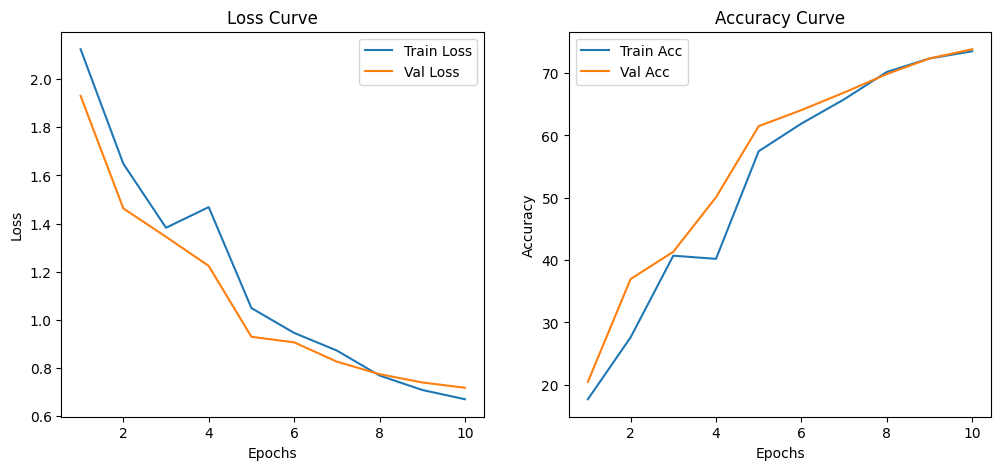

In [6]:
# ============================
# Plot Training & Validation Curves
# ============================

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [7]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Final evaluation on validation set
all_preds, all_labels = evaluate_model(model, val_loader, device)

# Calculate accuracy
final_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Validation Accuracy: {final_accuracy:.2f}%")

Evaluating: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]

Final Validation Accuracy: 73.83%


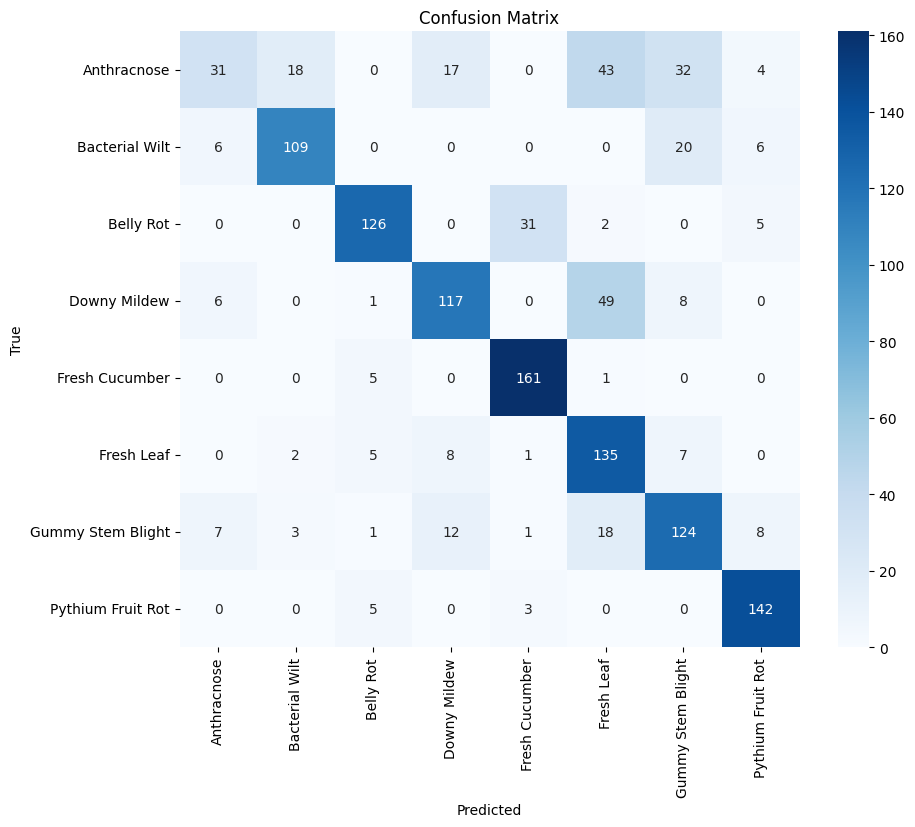


Classification Report:
                   precision    recall  f1-score   support

      Anthracnose       0.62      0.21      0.32       145
   Bacterial Wilt       0.83      0.77      0.80       141
        Belly Rot       0.88      0.77      0.82       164
     Downy Mildew       0.76      0.65      0.70       181
   Fresh Cucumber       0.82      0.96      0.88       167
       Fresh Leaf       0.54      0.85      0.67       158
Gummy Stem Blight       0.65      0.71      0.68       174
Pythium Fruit Rot       0.86      0.95      0.90       150

         accuracy                           0.74      1280
        macro avg       0.74      0.73      0.72      1280
     weighted avg       0.74      0.74      0.72      1280



In [8]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))